June 2018

Jupiter Notebook 5.5.0 (Python 3.5.5, Pandas 0.23.0, scikit-learn 0.19.1)

IPython Book #2 of 3

The goal of this exercise is to build a predictive model to determine which encounters will be followed by the patient being readmitted to the hospital within 30 days. 

In [1]:
# Load useful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Set the directory
# directory = [[ENTER DIRECTORY PATH]]


In [3]:
# Load the saved 'result' dataset (deduped, created in IPython Notebook #1)
import pickle
result = pd.read_pickle("result.pickle" )


# More data cleaning - missing values and dominant values

Note that variables admission_type_id, discharge_disposition_id, and admission_source_id show up as numeric variables but are in fact categorical. Make them strings so that Python recognizes them as categorical variables.

In [4]:
for i in ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']:
    result[i] = result[i].apply(str)


Next, I examine numeric and categorical variables for missing values and exclude any variables that are dominated by a single value (>=95% of values).

In [5]:
# Numeric variables
cols_numeric = result.describe(include = [np.number]).columns
cols_numeric

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'target'],
      dtype='object')

In [6]:
# Check if numeric variables have any missing values 
# Note, technically all missing values should be coded as '?' so missing vals would only apply to categorical variables
for i in cols_numeric[2:]:
    print(i, "    " ,result[i].isnull().values.any(),  "    ", result[i].isnull().values.sum())
    

time_in_hospital      False      0
num_lab_procedures      False      0
num_procedures      False      0
num_medications      False      0
number_outpatient      False      0
number_emergency      False      0
number_inpatient      False      0
number_diagnoses      False      0
target      False      0


Numeric variables have no missing values.

In [7]:
# Categorical variables
cols_categorical = result.describe(exclude = [np.number]).columns
cols_categorical


Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [8]:
# Check if categorical variables have any missing values 
for i in cols_categorical:
    try:
        
        var = result[i].value_counts()/result[i].value_counts().sum()
        print(i, "    ", format(var['?'], '.2f'))
    except:
        print(i, "---- NO MISSING")


race      0.03
gender ---- NO MISSING
age ---- NO MISSING
weight      0.96
admission_type_id ---- NO MISSING
discharge_disposition_id ---- NO MISSING
admission_source_id ---- NO MISSING
payer_code      0.42
medical_specialty      0.47
diag_1      0.00
diag_2      0.00
diag_3      0.02
max_glu_serum ---- NO MISSING
A1Cresult ---- NO MISSING
metformin ---- NO MISSING
repaglinide ---- NO MISSING
nateglinide ---- NO MISSING
chlorpropamide ---- NO MISSING
glimepiride ---- NO MISSING
acetohexamide ---- NO MISSING
glipizide ---- NO MISSING
glyburide ---- NO MISSING
tolbutamide ---- NO MISSING
pioglitazone ---- NO MISSING
rosiglitazone ---- NO MISSING
acarbose ---- NO MISSING
miglitol ---- NO MISSING
troglitazone ---- NO MISSING
tolazamide ---- NO MISSING
examide ---- NO MISSING
citoglipton ---- NO MISSING
insulin ---- NO MISSING
glyburide-metformin ---- NO MISSING
glipizide-metformin ---- NO MISSING
glimepiride-pioglitazone ---- NO MISSING
metformin-rosiglitazone ---- NO MISSING
metformin-pio

96% of weight values are missing. So I drop the 'weight' variable.

In [9]:
# Drop the weight variable and re-define cols_categorical
result = result.drop(['weight'], axis=1) 
cols_categorical = result.describe(exclude = [np.number]).columns


Next, I check if any categorical variables are dominated by a single value (>=95% of values). It turns out there are 17 such categorical variables so I drop them.

In [10]:
#Check which categorical variables have dominant values as defined above
drop_columns_categorical = []
for i in cols_categorical:
    top_percent = result[i].value_counts()[0]/result[i].value_counts().sum()
    if top_percent >= 0.95:
        print(i, "---", format(top_percent,'.3f'))
        drop_columns_categorical.append(i)
print(drop_columns_categorical)
print(len(drop_columns_categorical))

max_glu_serum --- 0.952
repaglinide --- 0.987
nateglinide --- 0.993
chlorpropamide --- 0.999
acetohexamide --- 1.000
tolbutamide --- 1.000
acarbose --- 0.997
miglitol --- 1.000
troglitazone --- 1.000
tolazamide --- 1.000
examide --- 1.000
citoglipton --- 1.000
glyburide-metformin --- 0.993
glipizide-metformin --- 1.000
glimepiride-pioglitazone --- 1.000
metformin-rosiglitazone --- 1.000
metformin-pioglitazone --- 1.000
['max_glu_serum', 'repaglinide', 'nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
17


In [11]:
# Drop 17 categorical variables with dominant values
result = result.drop(drop_columns_categorical, axis=1)

In [12]:
#re-define cols_categorical
cols_categorical = result.describe(exclude = [np.number]).columns


For numeric (continuous) variables, it is less likely that a single value will be present in 95% or more observations, unless there are lots of missing values or values like 0. The quickest way to examine numeric variables is to plot their histograms. 

In [13]:
# List numeric variable names
cols_numeric

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'target'],
      dtype='object')

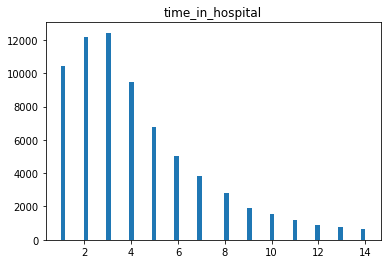

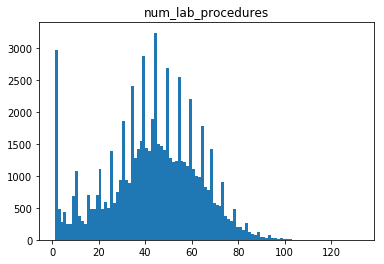

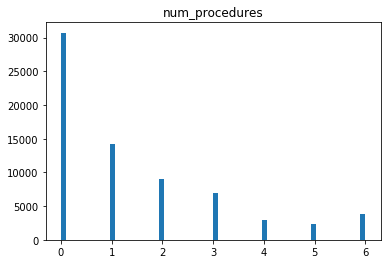

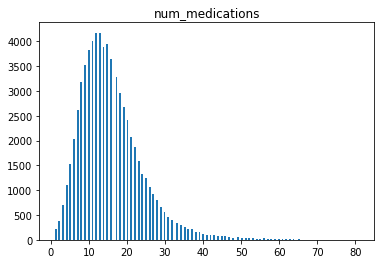

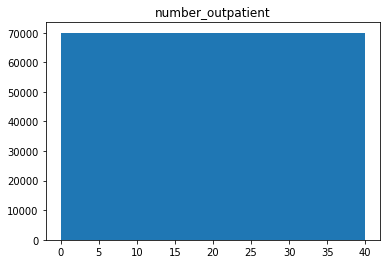

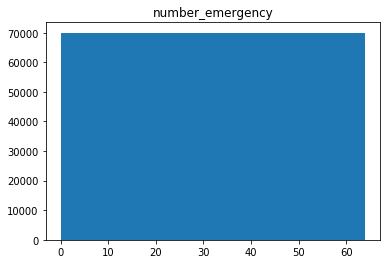

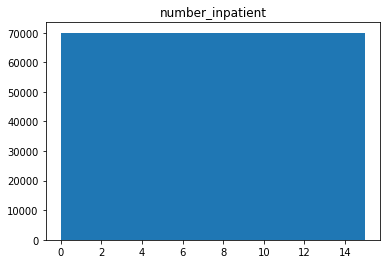

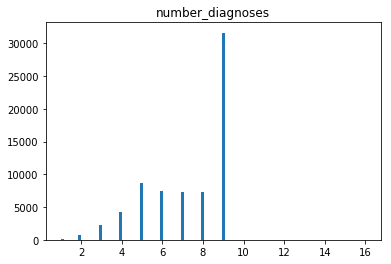

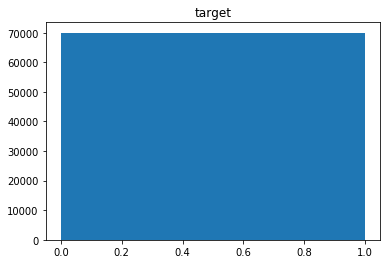

In [14]:
#Plot histograms for numeric variables (quickest way)
for i in cols_numeric[2:]:
    plt.hist(result[i], bins='auto')
    plt.title('%s' % i)
    plt.show()



In [15]:
# Check summary statistics for numeric variables
result[cols_numeric[2:]].describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,69990.0,4.279140,2.939000,1.0,2.0,3.0,6.0,14.0
num_lab_procedures,69990.0,43.007544,19.861828,1.0,31.0,44.0,57.0,132.0
num_procedures,69990.0,1.419789,1.749387,0.0,0.0,1.0,2.0,6.0
num_medications,69990.0,15.788227,8.306849,1.0,10.0,14.0,20.0,81.0
number_outpatient,69990.0,0.308015,1.132342,0.0,0.0,0.0,0.0,40.0
number_emergency,69990.0,0.125547,0.635568,0.0,0.0,0.0,0.0,64.0
number_inpatient,69990.0,0.302386,0.787538,0.0,0.0,0.0,0.0,15.0
number_diagnoses,69990.0,7.275582,1.984151,1.0,6.0,8.0,9.0,16.0
target,69990.0,0.125804,0.331630,0.0,0.0,0.0,0.0,1.0


Observation: Upon examining histograms of numeric variables, it does not appear that any one of them has a dominant value (i.e., a value that appears in 95% or more cases)

# Reduce cardinality of diab_1, diab_2, diab_3

In [16]:
result[cols_categorical].describe().T

,count,unique,top,freq
race,69990,6,Caucasian,52352
gender,69990,3,Female,37238
age,69990,10,[70-80),17726
admission_type_id,69990,8,1,35537
discharge_disposition_id,69990,21,1,43934
admission_source_id,69990,17,7,37236
payer_code,69990,18,?,29581
medical_specialty,69990,72,?,32800
diag_1,69990,692,414,5120
diag_2,69990,722,250,4878


Note that 'diag_1', 'diag_2', 'diag_3' have ~700 categories each. To reduce the cardinality of these variables, I use the provided ICD9 parent code mapping.  

In [17]:
# Load the abbreviated code mapping
codes = pd.read_csv(directory + 'cms_hcc_icd9_abbrev.csv', header = 0)


In [18]:
codes.head()

,icd9_abbrev,condition,n_code,max_n_code
0,003,Bone/Joint/Muscle Infections/Necrosis,2,2
1,006,"Pneumococcal Pneumonia, Empyema, Lung Abscess",1,1
2,007,Opportunistic Infections,1,1
3,020,"Pneumococcal Pneumonia, Empyema, Lung Abscess",3,3
4,021,"Pneumococcal Pneumonia, Empyema, Lung Abscess",1,1


In [19]:
# Check how diag_1 codes look like
pd.crosstab(index=result.diag_1, columns='count')[:3]

col_0,count
diag_1,
10,1
11,9
110,2


1) Note that icd9_abbrev codes have leading zeros, while diag_1 has none. So I strip leading zeros in the codes file.

In [20]:
codes.icd9_abbrev= codes.icd9_abbrev.str.lstrip('0')

In [21]:
codes.head()

,icd9_abbrev,condition,n_code,max_n_code
0,3,Bone/Joint/Muscle Infections/Necrosis,2,2
1,6,"Pneumococcal Pneumonia, Empyema, Lung Abscess",1,1
2,7,Opportunistic Infections,1,1
3,20,"Pneumococcal Pneumonia, Empyema, Lung Abscess",3,3
4,21,"Pneumococcal Pneumonia, Empyema, Lung Abscess",1,1


2) Next, I check if there is any difference between n_code and max_n_code. It turns out there is no difference, so I keep only n_code.

In [22]:
# Shows that n_code and max_n_code are identical
codes[codes.n_code != codes.max_n_code].shape[0]

0

In [23]:
# Drop the redundant max_n_code
codes = codes.drop('max_n_code', axis=1)

In [24]:
codes.head()

,icd9_abbrev,condition,n_code
0,3,Bone/Joint/Muscle Infections/Necrosis,2
1,6,"Pneumococcal Pneumonia, Empyema, Lung Abscess",1
2,7,Opportunistic Infections,1
3,20,"Pneumococcal Pneumonia, Empyema, Lung Abscess",3
4,21,"Pneumococcal Pneumonia, Empyema, Lung Abscess",1


3) Next, I check if the icd9_abbrev codes are unique.

In [25]:
# There are duplicates of icd9_abbrev since the output of the code below is not zero
codes[codes.duplicated(['icd9_abbrev'], keep=False)].shape[0]


31

In [26]:
# Moreover, we get the same number of duplicates if we dedupe codes by both icd9_abbrev and n_code
codes[codes.duplicated(['icd9_abbrev', 'n_code'], keep=False)].shape[0]


31

In [27]:
# But no duplicates exist if we also incorporate the condition variable, so it seems that the 'icd9_abbrev'-'n_code' pair can be
# associated with more than 1 'condition'
codes[codes.duplicated(['icd9_abbrev', 'condition', 'n_code'], keep=False)].shape[0]

0

In [28]:
# Check the number of unique icd9 codes
codes.icd9_abbrev.nunique()

306

In [29]:
# Check the number of unique n_code's
codes.n_code.nunique()

37

4) Because I want a many-to-one match when I merge 'result' with 'codes', I drop the 'condition' variable from 'codes' and dedupe 'codes' based on 'icd9_abbrev' and 'n_code'. This makes 'icd9_abbrev' unique in 'codes', and I will use 'n_code' in model buidling. Note that n_code has 37 categories vs. 306 categories in the abbreviated ICD9 codes.

In [30]:
codes_merge = codes.drop(['condition'], axis=1)

In [31]:
codes_merge = codes_merge.drop_duplicates(['icd9_abbrev', 'n_code'])

In [32]:
codes_merge.shape

(306, 2)

5) Before proceeding with the merger of 'result' and 'codes_merge', I make sure that 'diag_1', 'diag_2, and 'diag_3' have only 'parent codes', i.e., exclude anything after the "." for the small number of codes that have it.


In [33]:
# In diag_ variables, exclude anything after "."
for i in ['diag_1', 'diag_2', 'diag_3']:
    parent_code = result[i].str.split('.').str[0]
    result = result.join(parent_code, lsuffix='', rsuffix='_parent')
    result = result.drop([i], axis=1)


6) Now ready to do the merge:

In [34]:
# Now replace diag_1, diag_2, diag_3 with n_code from 'codes'
# diag_1
result = pd.merge(result, codes_merge, how='left', left_on='diag_1_parent', right_on='icd9_abbrev', indicator =True)


In [35]:
result[['diag_1_parent', 'icd9_abbrev', 'n_code', '_merge']].head()

,diag_1_parent,icd9_abbrev,n_code,_merge
0,401,NaN,NaN,left_only
1,722,NaN,NaN,left_only
2,820,820,18.0,both
3,274,NaN,NaN,left_only
4,590,NaN,NaN,left_only


In [36]:
m1 = pd.crosstab(index = result['_merge'], columns = 'count')
m1/m1.sum()

col_0,count
_merge,
left_only,0.440106
both,0.559894


Observation: Some diag_1 codes are not listed among the icd9_abbrev codes. 

In [37]:
# Drop variables that will not be used in modeling + rename n_code variable
result = result.drop(['icd9_abbrev', '_merge'], axis=1)
result = result.rename(columns= {'n_code': 'n_code_1'})

In [38]:
# Repeat the above steps for diag_2 and diag3

# diag_2
result = pd.merge(result, codes_merge, how='left', left_on='diag_2_parent', right_on='icd9_abbrev', indicator =True)
m2 = pd.crosstab(index = result['_merge'], columns = 'count')
print('Tabulation for diag_2 merge', m2/m2.sum())
result = result.drop(['icd9_abbrev', '_merge'], axis=1) # drop vars not used in modeling
result = result.rename(columns= {'n_code': 'n_code_2'}) # rename n_code


Tabulation for diag_2 merge col_0         count
_merge             
both       0.644978
left_only  0.355022


In [39]:
# diag_3
result = pd.merge(result, codes_merge, how='left', left_on='diag_3_parent', right_on='icd9_abbrev', indicator =True)
m3 = pd.crosstab(index = result['_merge'], columns = 'count')
print('Tabulation for diag_3 merge', m3/m3.sum())
result = result.drop(['icd9_abbrev', '_merge'], axis=1) # drop vars not used in modeling
result = result.rename(columns= {'n_code': 'n_code_3'}) # rename n_code


Tabulation for diag_3 merge col_0         count
_merge             
both       0.587984
left_only  0.412016


In [40]:
# Finally drop 'diag_1_parent','diag_2_parent', 'diag_3_parent' variables that have high cardinality
result = result.drop(['diag_1_parent','diag_2_parent', 'diag_3_parent'], axis=1)


In [41]:
result.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'A1Cresult', 'metformin', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'change', 'diabetesMed', 'readmitted', 'target', 'n_code_1', 'n_code_2',
       'n_code_3'],
      dtype='object')

In [42]:
# Check how many missing values the new n_code_ variables have:
for i in ['n_code_1', 'n_code_2', 'n_code_3']:
    print(i, "    " ,result[i].isnull().values.any(),  "    ", result[i].isnull().values.sum(),  "    ", 
          format(result[i].isnull().values.sum()/result.shape[0], '.2f'))
    

n_code_1      True      30803      0.44
n_code_2      True      24848      0.36
n_code_3      True      28837      0.41


7) The new 'n\_code_' variables have a relatively high number of missing values. I take a note of this and keep all 69,990 observations.

In [149]:
type(result.n_code_1[0])

numpy.float64

8) Next, note that the 'n\_code_' variables show up as numeric right now. So I need to convert them to categorical.

In [43]:
# Convert n_code_ vars to categorical vars
for i in ['n_code_1', 'n_code_2', 'n_code_3']:
    result[i] = result[i].apply(str)
    

In [44]:
# Update cols_numeric and cols_categorical
cols_numeric = result.describe(include = [np.number]).columns
print(cols_numeric)

cols_categorical = result.describe(exclude = [np.number]).columns
print(cols_categorical)


Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'target'],
      dtype='object')
Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'A1Cresult', 'metformin', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'change', 'diabetesMed', 'readmitted', 'n_code_1', 'n_code_2',
       'n_code_3'],
      dtype='object')


# Steady/Up/Down categories

Finally, I implement the following suggestion: "There are several variables indicating which medications the patient is on. Possible values for these fields are No/Steady/Up/Down.  For simplicity, you can treat these as binary where 0=No and 1=Steady/Up/Down."

These variables are: 'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone',  and 'insulin'.

In [45]:
for i in ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']:
    result[i] = np.where((result[i] == 'No'), 0,1) 

In [168]:
# Save the 'result' dataset and continue working in the next ipython notebook, where I experiment with decision tree models
# (since these do not require pre-processing such as de-meaning and standardization of numeric variables, or
# creation of dummy variables). 

# The pickle will be saved in the same folder where the IPython Notebook is located
import pickle
with open('result_book2.pickle', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to open, use this command:
#result = pd.read_pickle("result_book2.pickle" )

Continue to IPython Notebook #3 of 3